### Import Libraries

In [1]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import matplotlib.animation as animation
import tqdm
import matplotlib.patches as mpatches
import matplotlib.colors

### Load dicom images

In [3]:
VISUALIZE = False
# Directory of data
DATASET_DIR = r'../data/HCC-TACE-Seg/HCC_004/10-06-1997-NA-LIVERPELVIS-14785/5.000000-Recon 3 LIVER 3 PHASE AP-40661'
SEGMENT_DIR = r'../data/HCC-TACE-Seg/HCC_004/10-06-1997-NA-LIVERPELVIS-14785/300.000000-Segmentation-39561/1-1.dcm'
seg_dcm = pydicom.dcmread(SEGMENT_DIR)

In [4]:
# Object names and color configuration
OBJECTS = ['Liver', 'Mass', 'Portal vein', 'Abdominal aorta']
OBJECT_COLORS = [(1,0,0), (0,1,0), (0,0,1), (0,0.75,0.5)]

In [5]:
def load_dicom_images(folder_path):
    slices = []
    for f in os.listdir(folder_path):
        if f.lower().endswith(".dcm"):
            dicom_path = os.path.join(folder_path, f)
            slices.append(pydicom.dcmread(dicom_path))
    return slices

# Load CT slices
ct_slices = load_dicom_images(DATASET_DIR)
print(f"Loaded {len(ct_slices)} CT slices.")


Loaded 79 CT slices.


### Sort Slices

In [6]:
def sort_slices(ct_slices):
    return sorted(ct_slices, key=lambda x: -x.SliceLocation)

# Sort CT slices
ct_slices = sort_slices(ct_slices)
print(f"Sorted {len(ct_slices)} CT slices.")


Sorted 79 CT slices.


### Load Segmentation and Create Mask

In [7]:
seg_dcm = pydicom.dcmread(SEGMENT_DIR)
print("Segmentation DICOM loaded.")


Segmentation DICOM loaded.


In [8]:
def create_valid_masks(seg_dcm):
    valid_masks = {}
    series_dt = seg_dcm.PerFrameFunctionalGroupsSequence
    for i, frame in enumerate(series_dt):
        ref_ct = frame.DerivationImageSequence[0].SourceImageSequence[0].ReferencedSOPInstanceUID
        seg_id = str(frame.SegmentIdentificationSequence[0].ReferencedSegmentNumber)
        image_pos = frame.PlanePositionSequence[0].ImagePositionPatient
        valid_masks.setdefault(ref_ct, {})[seg_id] = {"idx": i, "image_position": image_pos}
    return valid_masks

# Create valid masks
valid_masks = create_valid_masks(seg_dcm)
print(f"Created valid masks for {len(valid_masks)} CT slices.")


Created valid masks for 79 CT slices.


### Reorder Segmentation

In [9]:
def reorder_segmentations(ct_slices, seg_dcm, valid_masks):
    seg_3d = np.array(seg_dcm.pixel_array)
    reordered_seg = []
    no_mask_count = 0
    for ct_dcm in ct_slices:
        mask = np.zeros(seg_3d[0].shape)
        uid = str(ct_dcm.SOPInstanceUID)
        if uid in valid_masks:
            for seg_id, info in valid_masks[uid].items():
                ref_mask = seg_3d[info["idx"]]
#                 print(ref_mask)
                mask[ref_mask == 1] = int(seg_id)
#                 print(mask)
        else:
            no_mask_count += 1
        reordered_seg.append(mask)
    return np.array(reordered_seg), no_mask_count

# Reorder segmentations
reordered_seg, no_mask_count = reorder_segmentations(ct_slices, seg_dcm, valid_masks)
print(f"Reordered segmentations with {no_mask_count} slices having no associated masks.")


Reordered segmentations with 0 slices having no associated masks.


In [10]:
# Extract pixel dimensions
pixel_len_mm = [ct_slices[0].SliceThickness] + list(ct_slices[0].PixelSpacing)

# Extract 3D images
img_3d = np.array([s.pixel_array for s in ct_slices])
print(f"Extracted 3D image array of shape {img_3d.shape}.")


Extracted 3D image array of shape (79, 512, 512).


In [11]:
def visualize_slices(img_3d, pixel_len_mm):
    for img in img_3d:
        plt.imshow(img, aspect=pixel_len_mm[1] / pixel_len_mm[2], cmap='bone')
        plt.title('CT slices on axial plane')
        plt.show()

# Visualize slices if VISUALIZE is set to True
if VISUALIZE:
    visualize_slices(img_3d, pixel_len_mm)


### Alpha Fusion

In [12]:

def alpha_fusion(img: np.ndarray, mask: np.ndarray, n_objects: int, object_colors: list, alpha: float = 0.5) -> np.ndarray:
    """
    Visualize both image and mask in the same plot using alpha blending.

    Parameters:
    img (np.ndarray): The input image array.
    mask (np.ndarray): The mask array corresponding to the image.
    n_objects (int): The number of different objects in the mask.
    object_colors (list): List of RGB tuples for each object.
    alpha (float): Alpha blending factor.

    Returns:
    np.ndarray: The alpha-fused image.
    """
    # Normalize the image using the 'bone' colormap
    cmap = plt.get_cmap('bone')
    norm = matplotlib.colors.Normalize(vmin=np.amin(img), vmax=np.amax(img))
    normalized_img = cmap(norm(img))[..., :3]

    # Initialize a colored mask with the same shape as the input mask, but with 3 color channels
    col_mask = np.zeros(list(mask.shape) + [3], dtype=np.float32)

    # Assign colors to each object in the mask
    for k in range(n_objects):
        col_mask[mask == (k + 1)] = object_colors[k]

    # Perform alpha blending
    fused_slice = (1 - alpha) * normalized_img + alpha * col_mask

    # Convert to 8-bit image
    fused_image = (fused_slice * 255).astype(np.uint8)

    return fused_image

In [13]:
# Alpha fusion of images and masks
img_segmented = [alpha_fusion(img, mask, len(OBJECTS), OBJECT_COLORS) for img, mask in zip(img_3d, reordered_seg)]
img_3d = np.array(img_segmented)
print(f"Alpha-fused image array of shape {img_3d.shape}.")


Alpha-fused image array of shape (79, 512, 512, 3).


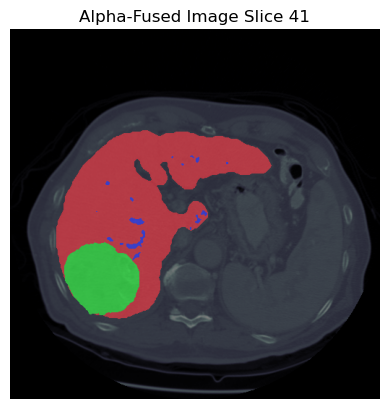

In [14]:
index_to_plot = 41 # You can change this index to plot different slices

# Plot the selected image
plt.imshow(img_segmented[index_to_plot])
plt.title(f'Alpha-Fused Image Slice {index_to_plot}')
plt.axis('off')  # Hide the axis
plt.show()

### Create Animation

In [15]:
pixel_len_mm

['2.5', '0.625', '0.625']

In [16]:

def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)

In [17]:
def MIP_per_plane(img_dcm: np.ndarray, axis: int = 2) -> np.ndarray:
    """ Compute the maximum intensity projection on the defined orientation. """
    return np.max(img_dcm, axis=axis)

In [18]:
def create_animation(img_dcm: np.ndarray, pixel_len_mm: list, labels: list, object_colors: list,
                     n=6, save_dir='results', show=True):
    """Creates an animation by rotating the image on its sagittal plane."""
    
    # Configure visualization colormap
    img_min = np.amin(img_dcm)
    img_max = np.amax(img_dcm)
    fig, ax = plt.subplots(figsize=(8, 10))

    # Configure directory to save results
    os.makedirs(save_dir, exist_ok=True)

    # Create projections
    projections = []

    # Creating legend for figures
    patches = [mpatches.Patch(color=color, label=label) for color, label in zip(object_colors, labels)]

    for idx, alpha in enumerate(tqdm.tqdm(np.linspace(0, 360 * (n - 1) / n, num=n), total=n)):
        rotated_img = rotate_on_axial_plane(img_dcm, alpha)
        projection = MIP_per_plane(rotated_img)
        plt.imshow(projection, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
        legend = plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 0.5))
        legend.set_title('Legend')
        plt.subplots_adjust(right=0.75)
        plt.savefig(os.path.join(save_dir, f'Projection_{idx}.png'), bbox_inches='tight')  # Save projection
        projections.append(projection)  # Save for later animation

    # Save and visualize animation
    animation_data = [
        [plt.imshow(img, animated=True, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])]
        for img in projections
    ]
    anim = animation.ArtistAnimation(fig, animation_data, interval=200, blit=True)
    anim.save(os.path.join(save_dir, 'Animation.gif'))  # Save animation
    if show:
        plt.show()  # Show animation
    plt.close()


In [19]:
create_animation(img_3d, pixel_len_mm, OBJECTS, OBJECT_COLORS, n=20, save_dir='results/results_20', show=VISUALIZE)

100%|███████████████████████████████████████████| 20/20 [04:52<00:00, 14.64s/it]
MovieWriter ffmpeg unavailable; using Pillow instead.
